# audio-waveform

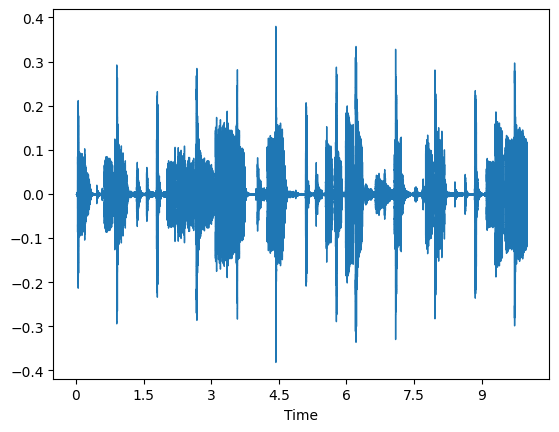

In [11]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
y, sr = librosa.load(librosa.ex('choice'), duration=10)
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y, sr=sr)

# frequency-spectrum

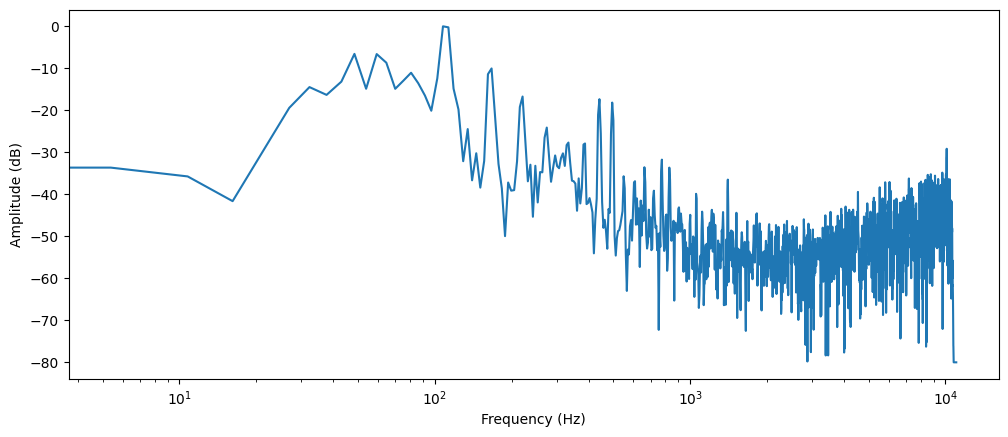

In [12]:
import numpy as np

dft_input = y[:4096]

window = np.hanning(len(dft_input))
windowed_input = dft_input * window
dft = np.fft.rfft(windowed_input)

amplitude = np.abs(dft)
amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

frequency = librosa.fft_frequencies(sr=sr, n_fft=len(dft_input))

plt.figure().set_figwidth(12)
plt.plot(frequency, amplitude_db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.xscale("log")

# spectrogram

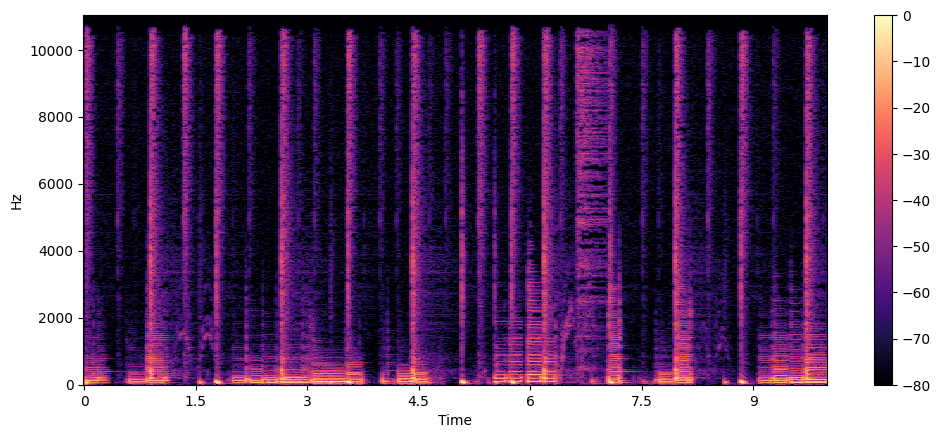

In [13]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

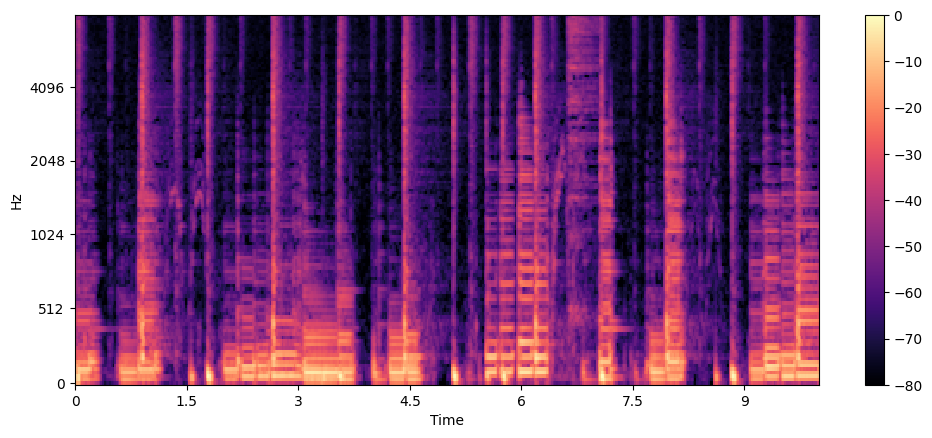

In [14]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=8000)
plt.colorbar()

# load-and-explore-audio-dataset

In [17]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [18]:
example = minds[0]
example

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [19]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'pay_bill'

In [20]:
columns_to_remove = ["lang_id", "english_transcription"]
minds = minds.remove_columns(columns_to_remove)
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [23]:
import gradio as gr

def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])

with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:183: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


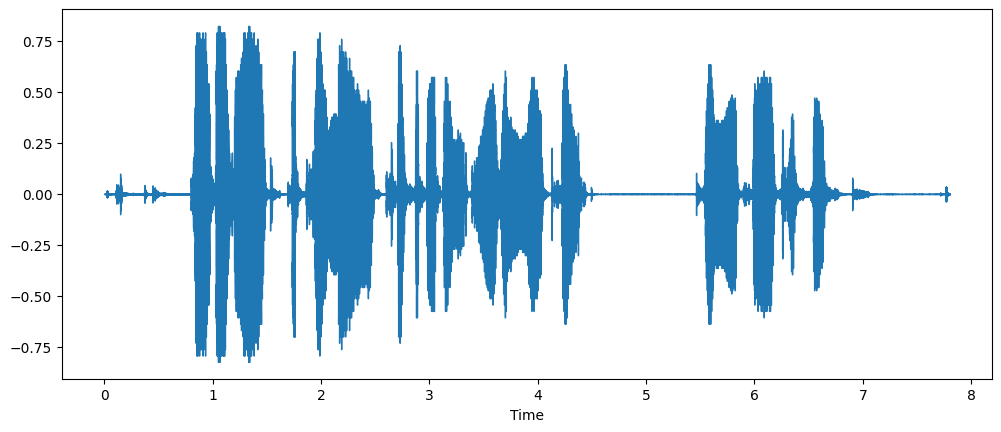

In [24]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]

plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

# preprocessing-audio-dataset

In [27]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [28]:
from datasets import Audio

minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [29]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

### Filtering the dataset

In [30]:
MAX_DURATION_IN_SECONDS = 20.0


def is_audio_length_in_range(input_length):
    return input_length < MAX_DURATION_IN_SECONDS

In [31]:
import librosa
# use librosa to get example's duration from the audio file
new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration", new_column)

# use 🤗 Datasets' `filter` method to apply the filtering function
minds = minds.filter(is_audio_length_in_range, input_columns=["duration"])

# remove the temporary helper column
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 624
})

In [34]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [35]:
def prepare_dataset(example):
    audio = example["audio"]
    features = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"], padding=True
    )
    return features

In [36]:
minds = minds.map(prepare_dataset)
minds

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id', 'input_features'],
    num_rows: 624
})

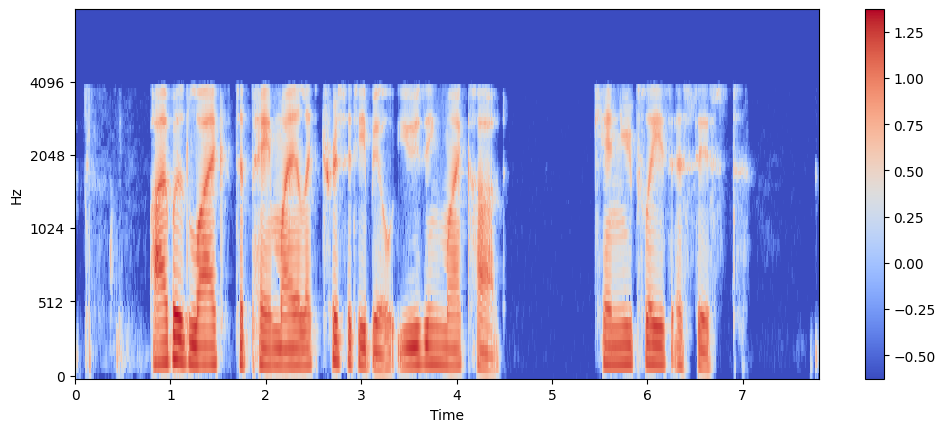

In [37]:
import numpy as np
import matplotlib.pyplot as plt

example = minds[0]
input_features = example["input_features"]

plt.figure().set_figwidth(12)
librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis="time",
    y_axis="mel",
    sr=feature_extractor.sampling_rate,
    hop_length=feature_extractor.hop_length,
)
plt.colorbar()

In [38]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("openai/whisper-small")

# audio-classification-with-pipeline

In [42]:
from datasets import load_dataset
from datasets import Audio

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [43]:
from transformers import pipeline

classifier = pipeline(
    "audio-classification",
    model="anton-l/xtreme_s_xlsr_300m_minds14",
)

In [60]:
example = minds[55]
example

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~FREEZE/response_28.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~FREEZE/response_28.wav',
  'array': array([ 3.47523019e-06,  1.00855104e-05, -4.35348920e-06, ...,
         -1.78918526e-05, -1.82851127e-05,  1.26426230e-05]),
  'sampling_rate': 16000},
 'transcription': 'please freeze my card',
 'english_transcription': 'please freeze my card',
 'intent_class': 9,
 'lang_id': 2}

In [61]:
classifier(example["audio"]["array"])

[{'score': 0.9985215067863464, 'label': 'freeze'},
 {'score': 0.0002955016097985208, 'label': 'card_issues'},
 {'score': 0.00024023927107919008, 'label': 'pay_bill'},
 {'score': 0.00022022565826773643, 'label': 'abroad'},
 {'score': 0.00018534639093559235, 'label': 'latest_transactions'}]

In [62]:
id2label = minds.features["intent_class"].int2str
id2label(example["intent_class"])

'freeze'

# asr-transformer-base

In [63]:
from transformers import pipeline

asr = pipeline("automatic-speech-recognition")

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
from datasets import load_dataset
from datasets import Audio

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds = minds.cast_column("audio", Audio(sampling_rate=16_000))

In [68]:
example = minds[55]
asr(example["audio"]["array"])

{'text': 'PLEASE PHRASE MY COD'}

# Classification and ASR assignment

In [69]:
from datasets import load_dataset

ds = load_dataset("facebook/voxpopuli", name="de", streaming=True)

In [70]:
ds_head = ds['train'].take(3)

In [71]:
example = list(ds_head)[-1]
example

{'audio_id': '20150908-0900-PLENARY-3-de_20150908-09:01:12_26',
 'language': 1,
 'audio': {'path': 'train_part_0/20150908-0900-PLENARY-3-de_20150908-09:01:12_26.wav',
  'array': array([-0.01617432, -0.05258179, -0.06607056, ...,  0.00396729,
         -0.00219727, -0.00396729]),
  'sampling_rate': 16000},
 'raw_text': 'Denn es gibt biologische Grenzen beim Tier.',
 'normalized_text': 'denn es gibt biologische grenzen beim tier.',
 'gender': 'female',
 'speaker_id': '4282',
 'is_gold_transcript': True,
 'accent': 'None'}

In [72]:
from IPython.display import Audio

Audio(example["audio"]["array"], rate=16000)

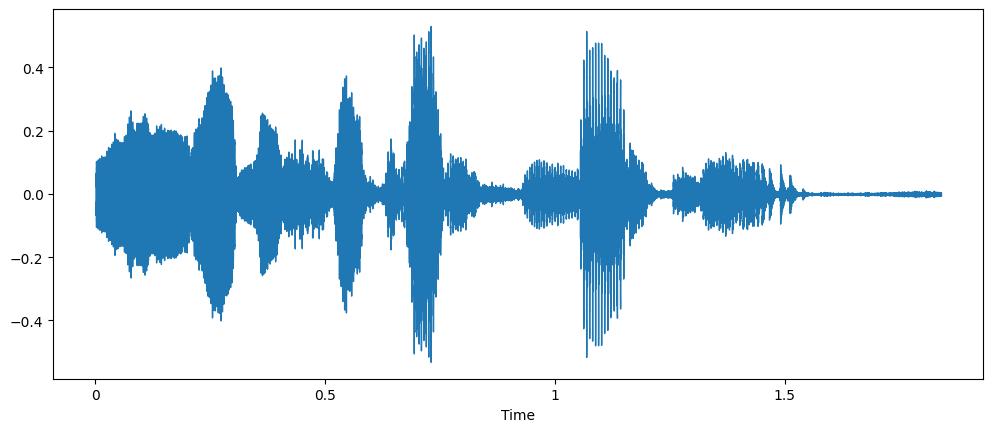

In [73]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = example["audio"]["array"]
sampling_rate = example["audio"]["sampling_rate"]
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

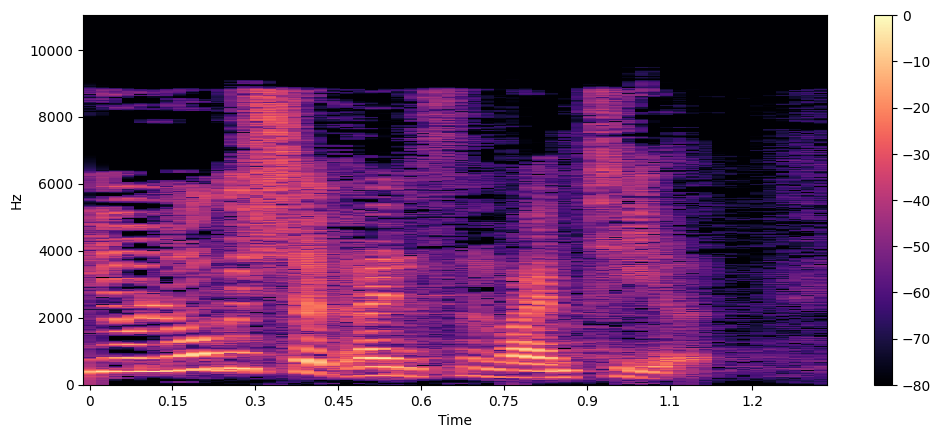

In [74]:
import numpy as np

D = librosa.stft(array)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
plt.colorbar()

In [75]:
from transformers import pipeline

asr = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-large-xlsr-53-german")

In [76]:
print(asr(example["audio"]["array"]))
print(example["raw_text"])

{'text': 'logihe grenzen beim tier'}
Denn es gibt biologische Grenzen beim Tier.


In [77]:
from IPython.display import Audio

Audio(example["audio"]["array"], rate=16000)

# pre-trained-models-and-datasets

In [78]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")

In [79]:
from transformers import pipeline

classifier = pipeline(
    "audio-classification",
    model="anton-l/xtreme_s_xlsr_300m_minds14",
)

In [80]:
classifier(minds[55]["path"])

[{'score': 0.9985232949256897, 'label': 'freeze'},
 {'score': 0.00029146039742045105, 'label': 'card_issues'},
 {'score': 0.00023920954845380038, 'label': 'pay_bill'},
 {'score': 0.0002197271678596735, 'label': 'abroad'},
 {'score': 0.0001865732338046655, 'label': 'latest_transactions'}]

In [81]:
speech_commands = load_dataset(
    "speech_commands", "v0.02", split="validation", streaming=True
)
sample = next(iter(speech_commands))

In [85]:
sample

{'id': 1326,
 'num_samples': 218880,
 'path': None,
 'audio': {},
 'transcription': 'in 1989 het hy vir brooks en groening gehelp om the simpsons te skep en hy was verantwoordelik om die eerste skrywerspan vir die program te huur',
 'raw_transcription': 'In 1989 het hy vir Brooks en Groening gehelp om The Simpsons te skep en hy was verantwoordelik om die eerste skrywerspan vir die program te huur.',
 'gender': 0,
 'lang_id': 0,
 'language': 'Afrikaans',
 'lang_group_id': 3}

### FLEURS (Few-shot Learning Evaluation of Universal Representations of Speech)

In [82]:
fleurs = load_dataset("google/fleurs", "all", split="validation", streaming=True)
sample = next(iter(fleurs))

In [83]:
classifier = pipeline(
    "audio-classification", model="sanchit-gandhi/whisper-medium-fleurs-lang-id"
)

In [84]:
classifier(sample["audio"])

[{'score': 0.9999330043792725, 'label': 'Afrikaans'},
 {'score': 7.093003659974784e-06, 'label': 'Northern-Sotho'},
 {'score': 4.269145392754581e-06, 'label': 'Icelandic'},
 {'score': 3.266111207267386e-06, 'label': 'Danish'},
 {'score': 3.258066044509178e-06, 'label': 'Cantonese Chinese'}]

### Zero-Shot Audio Classification

In [86]:
dataset = load_dataset("ashraq/esc50", split="train", streaming=True)
audio_sample = next(iter(dataset))["audio"]["array"]

Repo card metadata block was not found. Setting CardData to empty.


In [87]:
candidate_labels = ["Sound of a dog", "Sound of vacuum cleaner"]

In [88]:
Audio(audio_sample, rate=16000)

# music-classification

In [89]:
from datasets import load_dataset

gtzan = load_dataset("marsyas/gtzan", "all")
gtzan

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [94]:
gtzan["train"][0]

{'file': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/blues/blues.00000.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/5022b0984afa7334ff9a3c60566280b08b5179d4ac96a628052bada7d8940244/genres/blues/blues.00000.wav',
  'array': array([ 0.00732422,  0.01660156,  0.00762939, ..., -0.05560303,
         -0.06106567, -0.06417847]),
  'sampling_rate': 22050},
 'genre': 0}

In [95]:
id2label_fn = gtzan["train"].features["genre"].int2str
id2label_fn(gtzan["train"][0]["genre"])

'blues'

In [96]:
import gradio as gr


def generate_audio():
    example = gtzan["train"].shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label_fn(example["genre"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:183: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


### Preprocessing the data

In [97]:
from transformers import AutoFeatureExtractor

model_id = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)

In [98]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [99]:
from datasets import Audio

gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [100]:
import numpy as np

sample = gtzan["train"][0]["audio"]

print(f"Mean: {np.mean(sample['array']):.3}, Variance: {np.var(sample['array']):.3}")

Mean: -5.96e-05, Variance: 0.0198


In [101]:
inputs = feature_extractor(sample["array"], sampling_rate=sample["sampling_rate"])

print(f"inputs keys: {list(inputs.keys())}")

print(
    f"Mean: {np.mean(inputs['input_values']):.3}, Variance: {np.var(inputs['input_values']):.3}"
)

inputs keys: ['input_values', 'attention_mask']
Mean: 4.38e-09, Variance: 1.0


In [102]:
max_duration = 30.0


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [103]:
gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)
gtzan_encoded

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['genre', 'input_values', 'attention_mask'],
        num_rows: 999
    })
})

In [104]:
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")

In [106]:
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}

id2label["1"]

'classical'

In [107]:
from transformers import AutoModelForAudioClassification

num_labels = len(id2label)

model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.weight', 'projector.weight', 'projector.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [112]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!pip install accelerate -U

In [116]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 8
gradient_accumulation_steps = 1
num_train_epochs = 10

training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=True,
)

ImportError: ignored